# 1. Setup and get data

### 1.1 Install dependencies and setup

In [1]:
%pip install labelme tensorflow opencv-python matplotlib albumentations

Note: you may need to restart the kernel to use updated packages.


### 1.2 Collect images using OpenCv

In [2]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('../data', 'images')
number_images = 30

In [4]:
cap = cv2.VideoCapture(0)
for img_num in range(number_images):
    print(f'Collecting image #{img_num}')
    ret, frame = cap.read()
    img_name = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(img_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()

OUT OF LOOP


### 1.3 Annotate images with LabelMe

In [6]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: /Users/tomasmonaco/.labelmerc
2023-08-09 19:49:14.041 Python[91520:1587021] +[CATransaction synchronize] called within transaction
2023-08-09 19:49:28.835 Python[91520:1587021] +[CATransaction synchronize] called within transaction


# 2. Review dataset and build image loading fn

### 2.1 Import needed dependencies

In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

2023-08-09 20:25:33.097035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2.2 Load images into TF data pipeline

In [5]:
images = tf.data.Dataset.list_files('../data/images/*.jpg', shuffle=False)

In [6]:
def load_image(img_path):
    byte_img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [7]:
images = images.map(load_image)

In [8]:
images.as_numpy_iterator().next()

array([[[54, 53, 33],
        [57, 56, 36],
        [57, 54, 37],
        ...,
        [85, 86, 78],
        [88, 90, 79],
        [87, 89, 78]],

       [[71, 70, 50],
        [57, 56, 36],
        [62, 59, 42],
        ...,
        [85, 86, 78],
        [84, 86, 75],
        [89, 91, 80]],

       [[64, 63, 45],
        [61, 60, 42],
        [67, 64, 49],
        ...,
        [88, 89, 81],
        [90, 91, 83],
        [87, 88, 80]],

       ...,

       [[70, 65, 35],
        [65, 61, 32],
        [67, 61, 35],
        ...,
        [70, 79, 74],
        [73, 79, 75],
        [71, 78, 71]],

       [[71, 64, 36],
        [62, 57, 28],
        [67, 60, 34],
        ...,
        [74, 85, 77],
        [69, 79, 71],
        [79, 89, 80]],

       [[68, 61, 33],
        [68, 61, 33],
        [68, 60, 37],
        ...,
        [63, 76, 67],
        [67, 77, 68],
        [68, 78, 69]]], dtype=uint8)

### 2.3 View raw images with matplotlib

In [13]:
image_generator = images.batch(5).as_numpy_iterator()

In [14]:
plot_images = image_generator.next()

<function matplotlib.pyplot.show(close=None, block=None)>

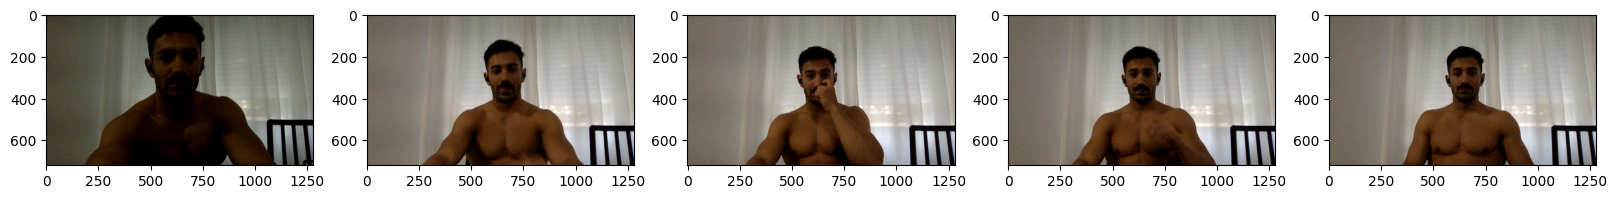

In [15]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show